# Initialize

In [ ]:
!pip install pytorch-lightning==1.6.5
!pip install pandas numpy opencv-python Pillow scikit-image scikit-learn scipy tqdm fairseq wandb statsmodels
%cd /content/drive/Shareddrives/THESIS/MAIN/visuelle2-code

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content/drive/Shareddrives/THESIS/MAIN/visuelle2-code


In [ ]:
import os
import argparse
import torch
import pandas as pd
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import numpy as np
from dataset import Visuelle2
from models.CrossAttnRNN21 import CrossAttnRNN as Model21
from models.CrossAttnRNN210 import CrossAttnRNN as Model210
from models.CrossAttnRNNDemand import CrossAttnRNN as DemandModel
from tqdm import tqdm
from utils import calc_error_metrics
from matplotlib import pyplot

In [ ]:
def run(args):
    print(args)

    # Seed for reproducibility (By default we use the number 21)
    pl.seed_everything(args.seed)

    ####################################### Load data #######################################
    test_df = pd.read_csv(
        os.path.join(args.dataset_path, "stfore_test.csv"),
        parse_dates=["release_date"],
    )

    # Load attribute encodings
    cat_dict = torch.load(os.path.join(args.dataset_path, "category_labels.pt"))
    col_dict = torch.load(os.path.join(args.dataset_path, "color_labels.pt"))
    fab_dict = torch.load(os.path.join(args.dataset_path, "fabric_labels.pt"))

    # Load Google trends
    gtrends = pd.read_csv(
        os.path.join(args.dataset_path, "vis2_gtrends_data.csv"), index_col=[0], parse_dates=True
    )

    demand = bool(args.new_product)
    img_folder = os.path.join(args.dataset_path, 'images')

    if demand:
      visuelle_pt_test = "visuelle2_test_processed_demand.pt"
    elif args.new_window == True:
      visuelle_pt_test = "visuelle2_test_processed_stfore_4.pt"
    else:
      visuelle_pt_test = "visuelle2_test_processed_stfore_2.pt"

    # Create (PyTorch) dataset objects
    testset = Visuelle2(
        test_df,
        img_folder,
        gtrends,
        cat_dict,
        col_dict,
        fab_dict,
        52,
        args.new_window,
        demand,
        local_savepath=os.path.join(args.dataset_path, visuelle_pt_test)
    )

    # # If you wish to debug with less data you can use this syntax
    # trainset = torch.utils.data.Subset(trainset, list(range(1000)))
    # testset = torch.utils.data.Subset(testset, list(range(1000)))
    testloader = DataLoader(
        testset, batch_size=args.batch_size, shuffle=False, num_workers=8
    )

    print(f"Test batches: {len(testloader)}")

    # ####################################### Train and eval model #######################################
    # Load model
    model_savename = args.ckpt_path
    if demand:
        model = DemandModel(
            attention_dim=args.attention_dim,
            embedding_dim=args.embedding_dim,
            hidden_dim=args.hidden_dim,
            num_trends=args.num_trends,
            cat_dict=cat_dict, 
            col_dict=col_dict, 
            fab_dict=fab_dict,
            store_num=125, #This represents the maximum encoded value of the store id, the actuall nr of stores available in the dataset is 110, but this is needed for the nn.Embedding layer to work
            use_img=args.use_img, 
            use_att=args.use_att, 
            use_date=args.use_date,
            use_trends=args.use_trends,
            out_len=12
        ).load_from_checkpoint(model_savename)
    else:
        if args.task_mode == 0:
            model = Model21(
                attention_dim=args.attention_dim,
                embedding_dim=args.embedding_dim,
                hidden_dim=args.hidden_dim,
                use_img=args.use_img,
                out_len=args.output_len,
            )
        else:
            model = Model210(
                attention_dim=args.attention_dim,
                embedding_dim=args.embedding_dim,
                hidden_dim=args.hidden_dim,
                use_img=args.use_img,
                out_len=args.output_len,
                use_teacher_forcing=args.use_teacher_forcing,
                teacher_forcing_ratio=args.teacher_forcing_ratio,
            )

        
    model.load_state_dict(torch.load(model_savename)['state_dict'])
    model.to('cuda:'+str(args.gpu_num)) 
    model.eval()

    gt, forecasts = [], []
    if demand == False:
      for data in tqdm(testloader, total=len(testloader)):
          with torch.no_grad():
              (X, y, _, _, _, _, _, gtrends), images = data
              X, y, images = X.to("cuda:"+str(args.gpu_num)), y.to("cuda:"+str(args.gpu_num)), images.to("cuda:"+str(args.gpu_num))
              y_hat, _ = model(X, y, images)
              forecasts.append(y_hat)
              gt.append(y)
    else:
       for data in tqdm(testloader, total=len(testloader)):
          with torch.no_grad():
              (ts, 
               categories, 
               colors, 
               fabrics, 
               stores, 
               temporal_features, 
               gtrends),  images = data

              (ts, 
               categories, 
               colors, 
               fabrics, 
               stores, 
               temporal_features, 
               gtrends, 
               images) = (ts.to("cuda:"+str(args.gpu_num)), 
                          categories.to("cuda:"+str(args.gpu_num)), 
                          colors.to("cuda:"+str(args.gpu_num)),
                          fabrics.to("cuda:"+str(args.gpu_num)),
                          stores.to("cuda:"+str(args.gpu_num)),
                          temporal_features.to("cuda:"+str(args.gpu_num)),
                          gtrends.to("cuda:"+str(args.gpu_num)),
                          images.to("cuda:"+str(args.gpu_num)))
              y_hat, _, _ = model(ts, 
               categories, 
               colors, 
               fabrics, 
               stores, 
               temporal_features, 
               gtrends, 
               images, 
               len(ts))
              forecasts.append(y_hat)
              gt.append(ts)
    norm_scalar = np.load(os.path.join(args.dataset_path, 'stfore_sales_norm_scalar.npy'))
    gt, forecasts = (
        torch.cat(gt).squeeze().detach().cpu().numpy() * norm_scalar,
        torch.cat(forecasts).squeeze().detach().cpu().numpy() * norm_scalar,
    )
    mae, wape = calc_error_metrics(gt, forecasts)
    print(f"{wape},{mae}")
    return gt, forecasts


In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("--dataset_path", type=str, default='visuelle2/')
parser.add_argument("--seed", type=int, default=21)
parser.add_argument("--batch_size", type=int, default=128)
parser.add_argument("--new_product", type=int, default=0,
help="Boolean variable to optionally use the dataset for the new product demand forecasting task (forecasting without a known past)")

# Model specific arguments
parser.add_argument("--embedding_dim", type=int, default=512)
parser.add_argument("--attention_dim", type=int, default=512)
parser.add_argument("--hidden_dim", type=int, default=512)
parser.add_argument("--output_len", type=int, default=10)
parser.add_argument("--use_img", type=bool, default=True)
parser.add_argument("--use_att", type=bool, default=True)
parser.add_argument("--use_date", type=bool, default=True)
parser.add_argument("--use_trends", type=bool, default=True)
parser.add_argument("--num_trends", type=int, default=3)
parser.add_argument("--task_mode", type=int, default=0, help="0-->2-1 - 1-->2-10")
parser.add_argument("--new_window", type=bool, default=False)
parser.add_argument("--epochs", type=int, default=50)
parser.add_argument("--gpu_num", type=int, default=0)
parser.add_argument("--use_teacher_forcing", action='store_true')
parser.add_argument("--teacher_forcing_ratio", type=float, default=0.3)


# wandb arguments
parser.add_argument('-f')
parser.add_argument("--ckpt_path", type=str, default="ckpt/model.ckpt")

# args = parser.parse_args()
args, unknown = parser.parse_known_args()

# SO-fore 4-1 w/image attention

In [ ]:
gt, forecasts = 0, 0
if __name__ == "__main__":
  args.new_window = True
  args.task_mode = 0
  args.ckpt_path = 'ckpt/---epoch=4---04-02-2023-18-54-08.ckpt'
  gt, forecasts = run(args)

INFO:pytorch_lightning.utilities.seed:Global seed set to 21


Namespace(attention_dim=512, batch_size=128, ckpt_path='ckpt/---epoch=4---04-02-2023-18-54-08.ckpt', dataset_path='visuelle2/', embedding_dim=512, epochs=50, f='/root/.local/share/jupyter/runtime/kernel-fdb92dc2-2342-42c4-840c-bb20cb342ace.json', gpu_num=0, hidden_dim=512, new_product=0, new_window=True, num_trends=3, output_len=10, seed=21, task_mode=0, teacher_forcing_ratio=0.3, use_att=True, use_date=True, use_img=True, use_teacher_forcing=False, use_trends=True)
Loading dataset...
Done.
Test batches: 84


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can al

91.857,0.9559999704360962


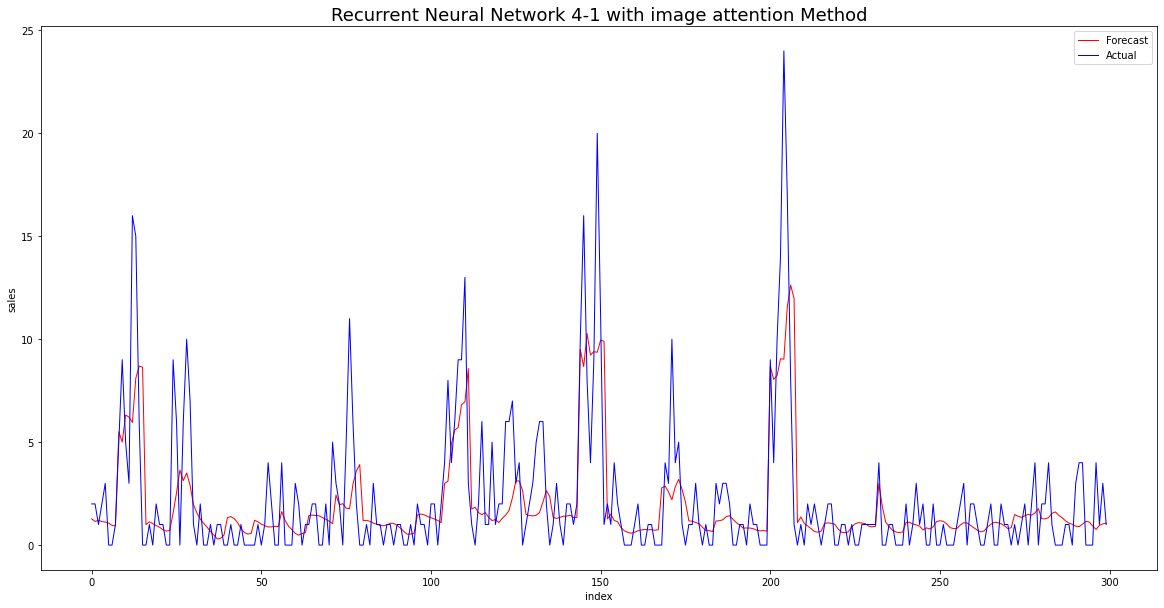

In [ ]:
df = pd.DataFrame(gt.flatten(), columns=['Actual'])
df['Forecast']=forecasts.flatten()
pyplot.figure(figsize=(20, 10))
pyplot.plot(df['Forecast'].iloc[:300],label='Forecast', linewidth=1, color='red')
pyplot.plot(df['Actual'].iloc[:300], label='Actual', linewidth=1, color='blue')
pyplot.xlabel('index')
pyplot.ylabel('sales')
pyplot.title('Recurrent Neural Network 4-1 with image attention Method', fontsize=18)
pyplot.legend()
pyplot.show()

# SO-fore 2-1 w/image attention

In [ ]:
gt, forecasts = 0, 0
if __name__ == "__main__":
  args.new_window = False
  args.task_mode = 0
  args.ckpt_path = 'ckpt/---epoch=4---04-02-2023-20-29-53.ckpt'
  gt, forecasts = run(args)

INFO:pytorch_lightning.utilities.seed:Global seed set to 21


Namespace(attention_dim=512, batch_size=128, ckpt_path='ckpt/---epoch=4---04-02-2023-20-29-53.ckpt', dataset_path='visuelle2/', embedding_dim=512, epochs=50, f='/root/.local/share/jupyter/runtime/kernel-fdb92dc2-2342-42c4-840c-bb20cb342ace.json', gpu_num=0, hidden_dim=512, new_product=0, new_window=False, num_trends=3, output_len=10, seed=21, task_mode=0, teacher_forcing_ratio=0.3, use_att=True, use_date=True, use_img=True, use_teacher_forcing=False, use_trends=True)
Loading dataset...
Done.
Test batches: 84


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can al

  0%|          | 0.00/104M [00:00<?, ?B/s]

100%|██████████| 84/84 [02:46<00:00,  1.98s/it]


88.116,0.9779999852180481


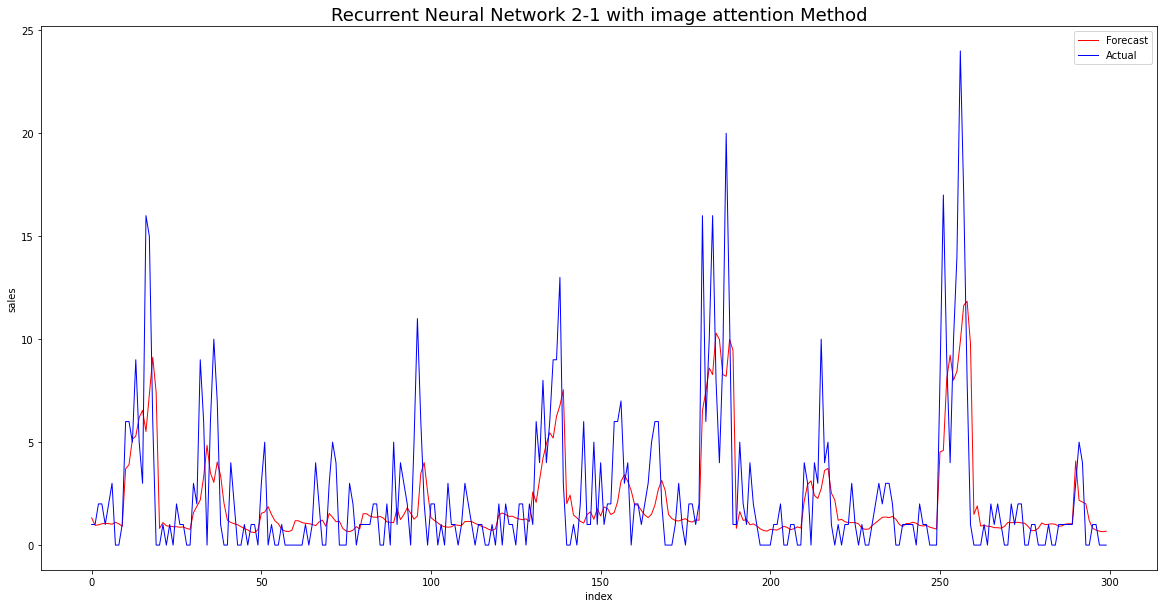

In [ ]:
df = pd.DataFrame(gt.flatten(), columns=['Actual'])
df['Forecast']=forecasts.flatten()
pyplot.figure(figsize=(20, 10))
pyplot.plot(df['Forecast'].iloc[:300],label='Forecast', linewidth=1, color='red')
pyplot.plot(df['Actual'].iloc[:300], label='Actual', linewidth=1, color='blue')
pyplot.xlabel('index')
pyplot.ylabel('sales')
pyplot.title('Recurrent Neural Network 2-1 with image attention Method', fontsize=18)
pyplot.legend()
pyplot.show()

# SO-fore 4-1

In [ ]:
gt, forecasts = 0, 0
if __name__ == "__main__":
  args.new_window = True
  args.task_mode = 0
  args.ckpt_path = 'ckpt/---epoch=3---30-01-2023-11-06-35.ckpt'
  gt, forecasts = run(args)

INFO:pytorch_lightning.utilities.seed:Global seed set to 21


Namespace(attention_dim=512, batch_size=128, ckpt_path='ckpt/---epoch=3---30-01-2023-11-06-35.ckpt', dataset_path='visuelle2/', embedding_dim=512, epochs=50, f='/root/.local/share/jupyter/runtime/kernel-1aa94c5a-2faa-4bcc-85fd-7b3b8ebb0bc0.json', gpu_num=0, hidden_dim=512, new_product=0, new_window=True, num_trends=3, output_len=10, seed=21, task_mode=0, teacher_forcing_ratio=0.3, use_att=True, use_date=True, use_img=True, use_teacher_forcing=False, use_trends=True)
Loading dataset...
Done.
Test batches: 84


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can al

94.907,0.9879999756813049


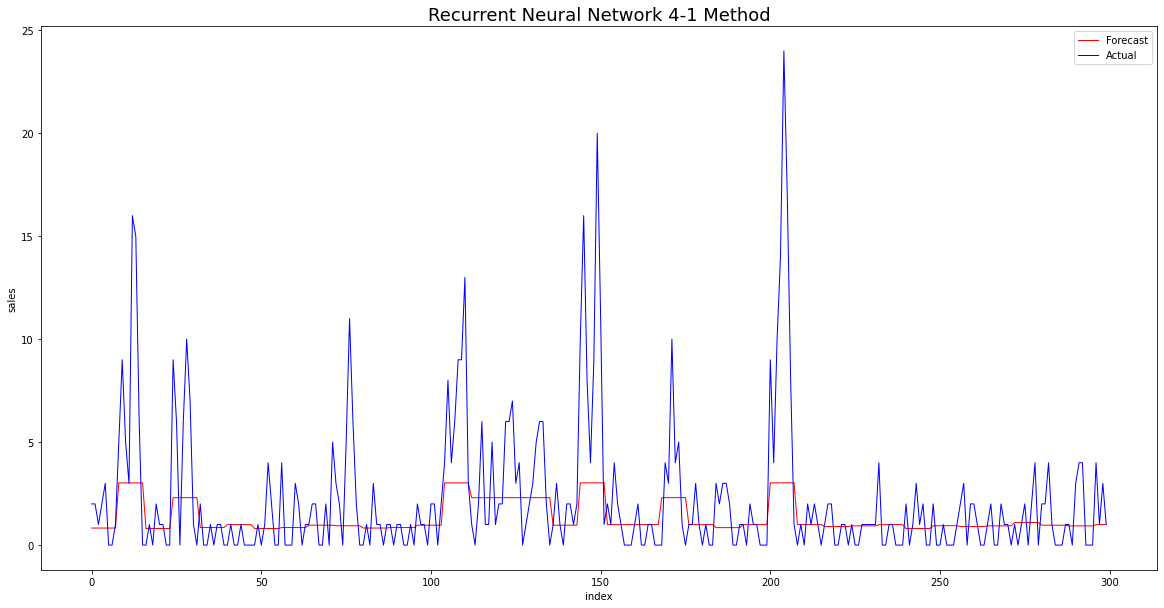

In [ ]:
df = pd.DataFrame(gt.flatten(), columns=['Actual'])
df['Forecast']=forecasts.flatten()
pyplot.figure(figsize=(20, 10))
pyplot.plot(df['Forecast'].iloc[:300],label='Forecast', linewidth=1, color='red')
pyplot.plot(df['Actual'].iloc[:300], label='Actual', linewidth=1, color='blue')
pyplot.xlabel('index')
pyplot.ylabel('sales')
pyplot.title('Recurrent Neural Network 4-1 Method', fontsize=18)
pyplot.legend()
pyplot.show()

# SO-fore 2-1

In [ ]:
gt, forecasts = 0, 0
if __name__ == "__main__":
  args.new_window = False
  args.task_mode = 0
  args.ckpt_path = 'ckpt/---epoch=3---30-01-2023-12-58-35.ckpt'
  gt, forecasts = run(args)

INFO:pytorch_lightning.utilities.seed:Global seed set to 21


Namespace(attention_dim=512, batch_size=128, ckpt_path='ckpt/---epoch=3---30-01-2023-12-58-35.ckpt', dataset_path='visuelle2/', embedding_dim=512, epochs=50, f='/root/.local/share/jupyter/runtime/kernel-1aa94c5a-2faa-4bcc-85fd-7b3b8ebb0bc0.json', gpu_num=0, hidden_dim=512, new_product=0, new_window=False, num_trends=3, output_len=10, seed=21, task_mode=0, teacher_forcing_ratio=0.3, use_att=True, use_date=True, use_img=True, use_teacher_forcing=False, use_trends=True)
Loading dataset...
Done.
Test batches: 84


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can al

90.393,1.003000020980835


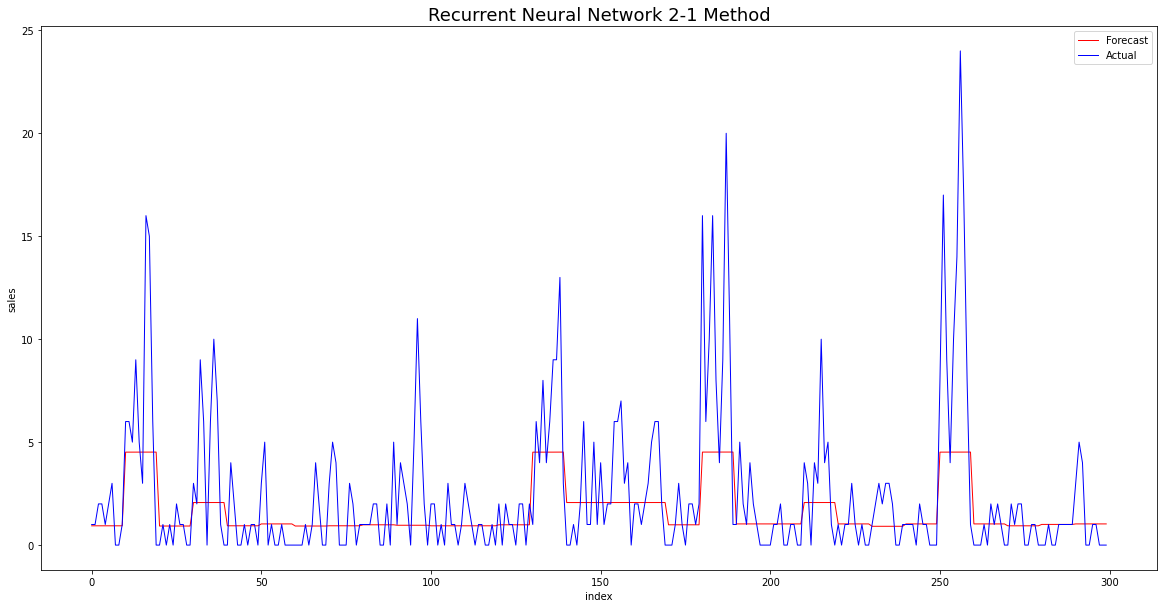

In [ ]:
df = pd.DataFrame(gt.flatten(), columns=['Actual'])
df['Forecast']=forecasts.flatten()
pyplot.figure(figsize=(20, 10))
pyplot.plot(df['Forecast'].iloc[:300],label='Forecast', linewidth=1, color='red')
pyplot.plot(df['Actual'].iloc[:300], label='Actual', linewidth=1, color='blue')
pyplot.xlabel('index')
pyplot.ylabel('sales')
pyplot.title('Recurrent Neural Network 2-1 Method', fontsize=18)
pyplot.legend()
pyplot.show()

# SO-fore 4-8 w/image attention

In [ ]:
gt, forecasts = 0, 0
if __name__ == "__main__":
  args.new_window = True
  args.task_mode = 1
  args.output_len = 8
  args.ckpt_path = 'ckpt/---epoch=4---30-01-2023-14-25-19.ckpt'
  gt, forecasts = run(args)

INFO:pytorch_lightning.utilities.seed:Global seed set to 21


Namespace(attention_dim=512, batch_size=128, ckpt_path='ckpt/---epoch=4---30-01-2023-14-25-19.ckpt', dataset_path='visuelle2/', embedding_dim=512, epochs=50, f='/root/.local/share/jupyter/runtime/kernel-fdb92dc2-2342-42c4-840c-bb20cb342ace.json', gpu_num=0, hidden_dim=512, new_product=0, new_window=True, num_trends=3, output_len=8, seed=21, task_mode=1, teacher_forcing_ratio=0.3, use_att=True, use_date=True, use_img=True, use_teacher_forcing=False, use_trends=True)
Loading dataset...
Done.
Test batches: 84


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can al

91.391,0.9509999752044678


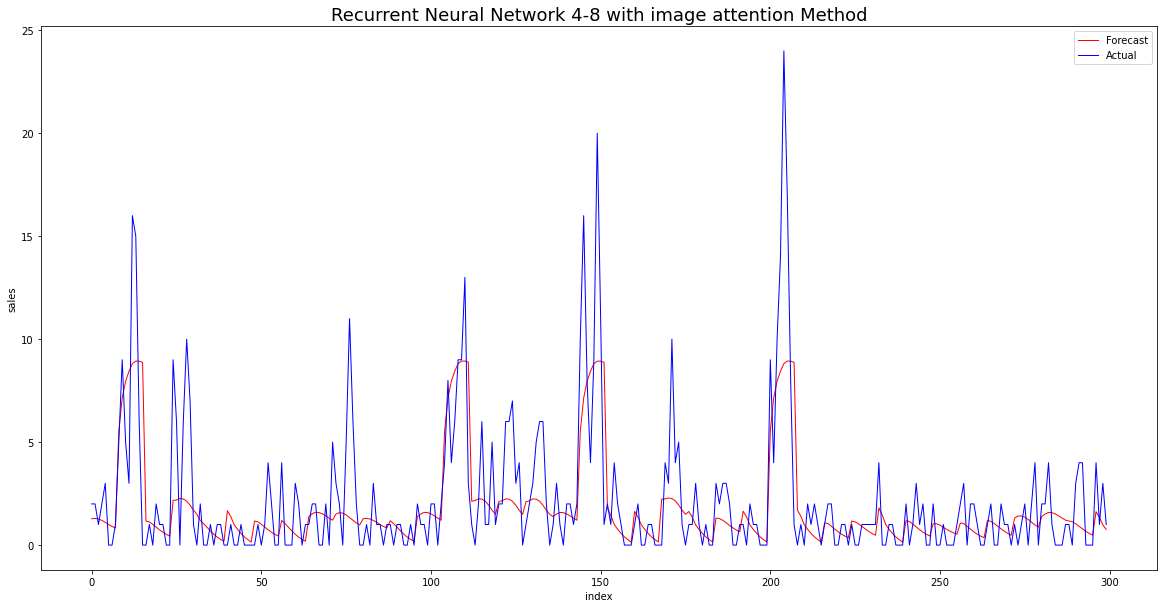

In [ ]:
df = pd.DataFrame(gt.flatten(), columns=['Actual'])
df['Forecast']=forecasts.flatten()
pyplot.figure(figsize=(20, 10))
pyplot.plot(df['Forecast'].iloc[:300],label='Forecast', linewidth=1, color='red')
pyplot.plot(df['Actual'].iloc[:300], label='Actual', linewidth=1, color='blue')
pyplot.xlabel('index')
pyplot.ylabel('sales')
pyplot.title('Recurrent Neural Network 4-8 with image attention Method', fontsize=18)
pyplot.legend()
pyplot.show()

# SO-fore 2-10 w/image attention

In [ ]:
gt, forecasts = 0, 0
if __name__ == "__main__":
  args.new_window = False
  args.task_mode = 1
  args.output_len = 10
  args.ckpt_path = 'ckpt/---epoch=1---30-01-2023-15-59-08.ckpt'
  gt, forecasts = run(args)

INFO:pytorch_lightning.utilities.seed:Global seed set to 21


Namespace(attention_dim=512, batch_size=128, ckpt_path='ckpt/---epoch=1---30-01-2023-15-59-08.ckpt', dataset_path='visuelle2/', embedding_dim=512, epochs=50, f='/root/.local/share/jupyter/runtime/kernel-fdb92dc2-2342-42c4-840c-bb20cb342ace.json', gpu_num=0, hidden_dim=512, new_product=0, new_window=False, num_trends=3, output_len=10, seed=21, task_mode=1, teacher_forcing_ratio=0.3, use_att=True, use_date=True, use_img=True, use_teacher_forcing=False, use_trends=True)
Loading dataset...
Done.
Test batches: 84


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can al

90.876,1.0089999437332153


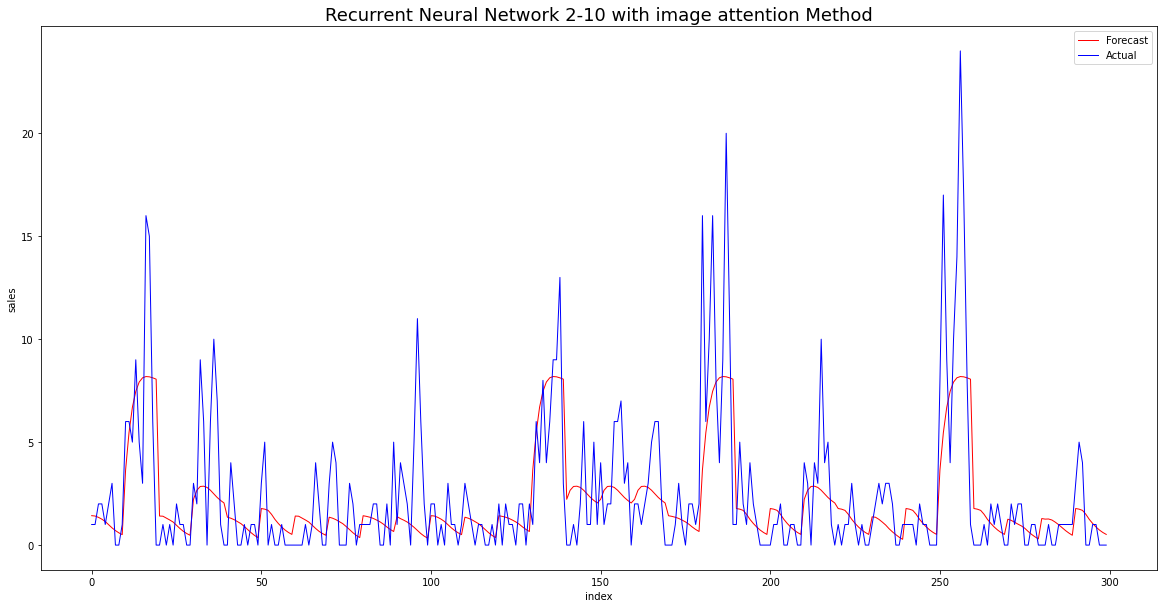

In [ ]:
df = pd.DataFrame(gt.flatten(), columns=['Actual'])
df['Forecast']=forecasts.flatten()
pyplot.figure(figsize=(20, 10))
pyplot.plot(df['Forecast'].iloc[:300],label='Forecast', linewidth=1, color='red')
pyplot.plot(df['Actual'].iloc[:300], label='Actual', linewidth=1, color='blue')
pyplot.yticks(range(0,25,5))
pyplot.xlabel('index')
pyplot.ylabel('sales')
pyplot.title('Recurrent Neural Network 2-10 with image attention Method', fontsize=18)
pyplot.legend()
pyplot.show()

# SO Demand

In [ ]:
gt, forecasts = 0, 0
if __name__ == "__main__":
  args.new_product = 1
  args.ckpt_path = 'ckpt/---epoch=2---30-01-2023-17-21-36.ckpt'
  gt, forecasts = run(args)

INFO:pytorch_lightning.utilities.seed:Global seed set to 21


Namespace(attention_dim=512, batch_size=128, ckpt_path='ckpt/---epoch=2---30-01-2023-17-21-36.ckpt', dataset_path='visuelle2/', embedding_dim=512, epochs=50, f='/root/.local/share/jupyter/runtime/kernel-1aa94c5a-2faa-4bcc-85fd-7b3b8ebb0bc0.json', gpu_num=0, hidden_dim=512, new_product=1, new_window=False, num_trends=3, output_len=10, seed=21, task_mode=0, teacher_forcing_ratio=0.3, use_att=True, use_date=True, use_img=True, use_teacher_forcing=False, use_trends=True)
Loading dataset...
Loading exogenous time series...


100%|██████████| 10684/10684 [00:17<00:00, 595.35it/s]
/content/drive/Shareddrives/THESIS/MAIN/visuelle2-code/dataset.py:211: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  gtrends = torch.FloatTensor(gtrends).type(torch.float32)
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarnin

Done.
Test batches: 84


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

100%|██████████| 84/84 [02:09<00:00,  1.54s/it]

84.268,0.9929999709129333


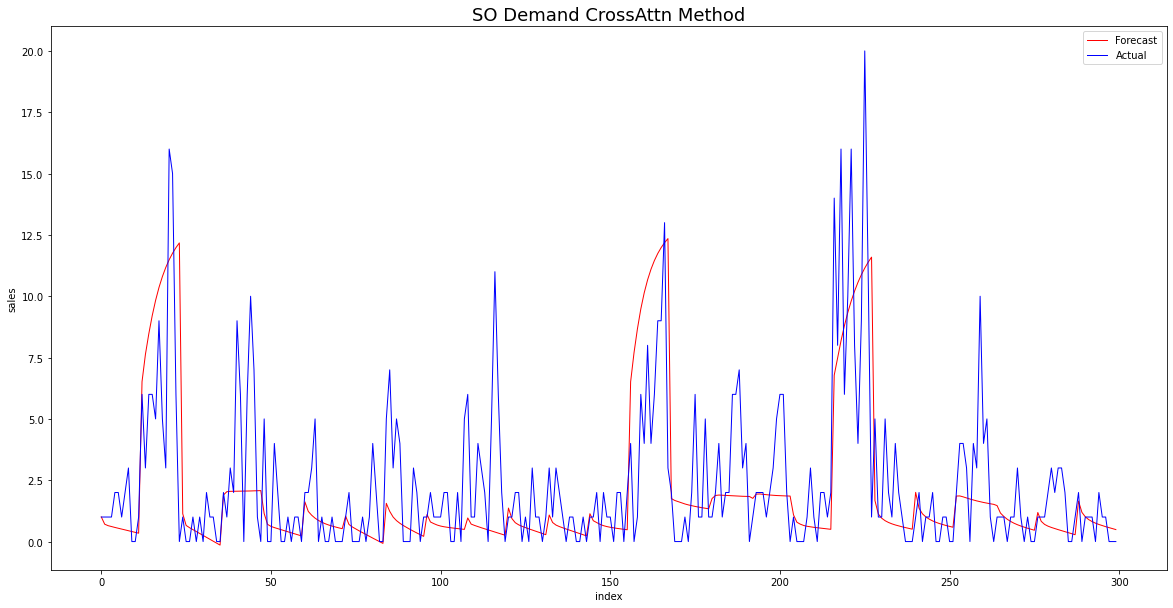

In [ ]:
df = pd.DataFrame(gt.flatten(), columns=['Actual'])
df['Forecast']=forecasts.flatten()
pyplot.figure(figsize=(20, 10))
pyplot.plot(df['Forecast'].iloc[:300],label='Forecast', linewidth=1, color='red')
pyplot.plot(df['Actual'].iloc[:300], label='Actual', linewidth=1, color='blue')
pyplot.xlabel('index')
pyplot.ylabel('sales')
pyplot.title('SO Demand CrossAttn Method', fontsize=18)
pyplot.legend()
pyplot.show()